In [37]:
import sklearn
import numpy as np
import os
import datetime,time
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from prettytable import PrettyTable
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.get_lock().locks = []
import concurrent.futures
from copy import deepcopy       
from functools import partial
from itertools import combinations
import random
from random import randint, uniform
import gc
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from itertools import combinations
from sklearn.impute import SimpleImputer
import xgboost as xg
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_squared_log_error, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.cluster import KMeans
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
from optuna.samplers import TPESampler, CmaEsSampler, RandomSampler
import cmaes
import xgboost as xgb
import lightgbm as lgb

from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier

from imblearn.ensemble import BalancedRandomForestClassifier
# from sklearn.datasets import make_classification
# from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
#from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LogisticRegressionCV
# from sklearn.neural_network import MLPClassifier
#from catboost import Pool
import re
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


import tensorflow
import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Activation, LeakyReLU, PReLU, ELU, Dropout

from keras.utils import to_categorical
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim

from concurrent.futures import ThreadPoolExecutor
from colorama import Fore, Style
from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None
pd.pandas.set_option('display.max_columns', None)

In [38]:
global device

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
    device = 'gpu'
else:
    print("GPU is not available")
    device = 'cpu'

train=pd.read_csv('train.csv').rename(columns={'temparature':'temperature'})
test=pd.read_csv('test.csv').rename(columns={'temparature':'temperature'})
original=pd.read_csv("Rainfall.csv").rename(columns={'temparature':'temperature'})
submission=pd.read_csv("sample_submission.csv")

train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)
original['rainfall'] = original['rainfall'].map({'yes': 1, 'no': 0})
original.columns=[f.strip() for f in original.columns]

train_copy=train.copy()
test_copy=test.copy()
original_copy=original.copy()

original["original"]=1

train["original"]=0
test["original"]=0

train=pd.concat([train,original],axis=0)
train.reset_index(inplace=True,drop=True)

target='rainfall'

train.head()

GPU is not available


,day,pressure,maxtemp,temperature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,original
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,0
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,0
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,0
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,0


In [39]:
#missing values
table = PrettyTable()
table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %', "Original Missing%", "Discrete Ratio (Train)"]

for column in train_copy.columns:
    data_type = str(train_copy[column].dtype)
    
    # Calculate missing percentages
    non_null_count_train = np.round(100-train_copy[column].count()/train_copy.shape[0]*100, 1)
    
    if column != target:
        non_null_count_test = np.round(100-test_copy[column].count()/test_copy.shape[0]*100, 1)
    else:
        non_null_count_test = "NA"
        
    non_null_count_orig = np.round(100-original_copy[column].count()/original_copy.shape[0]*100, 1)
    
    # Calculate discrete nature ratio (unique values / total values)
    discrete_ratio = np.round(train_copy[column].nunique() / train_copy.shape[0], 4)
    
    table.add_row([column, data_type, non_null_count_train, non_null_count_test, non_null_count_orig, discrete_ratio])

print(table)

+---------------+-----------+-----------------+----------------+-------------------+------------------------+
|    Feature    | Data Type | Train Missing % | Test Missing % | Original Missing% | Discrete Ratio (Train) |
+---------------+-----------+-----------------+----------------+-------------------+------------------------+
|      day      |   int64   |       0.0       |      0.0       |        0.0        |         0.1667         |
|    pressure   |  float64  |       0.0       |      0.0       |        0.0        |         0.1078         |
|    maxtemp    |  float64  |       0.0       |      0.0       |        0.0        |          0.1           |
|  temperature  |  float64  |       0.0       |      0.0       |        0.0        |         0.0904         |
|    mintemp    |  float64  |       0.0       |      0.0       |        0.0        |         0.0909         |
|    dewpoint   |  float64  |       0.0       |      0.0       |        0.0        |         0.0995         |
|    humid

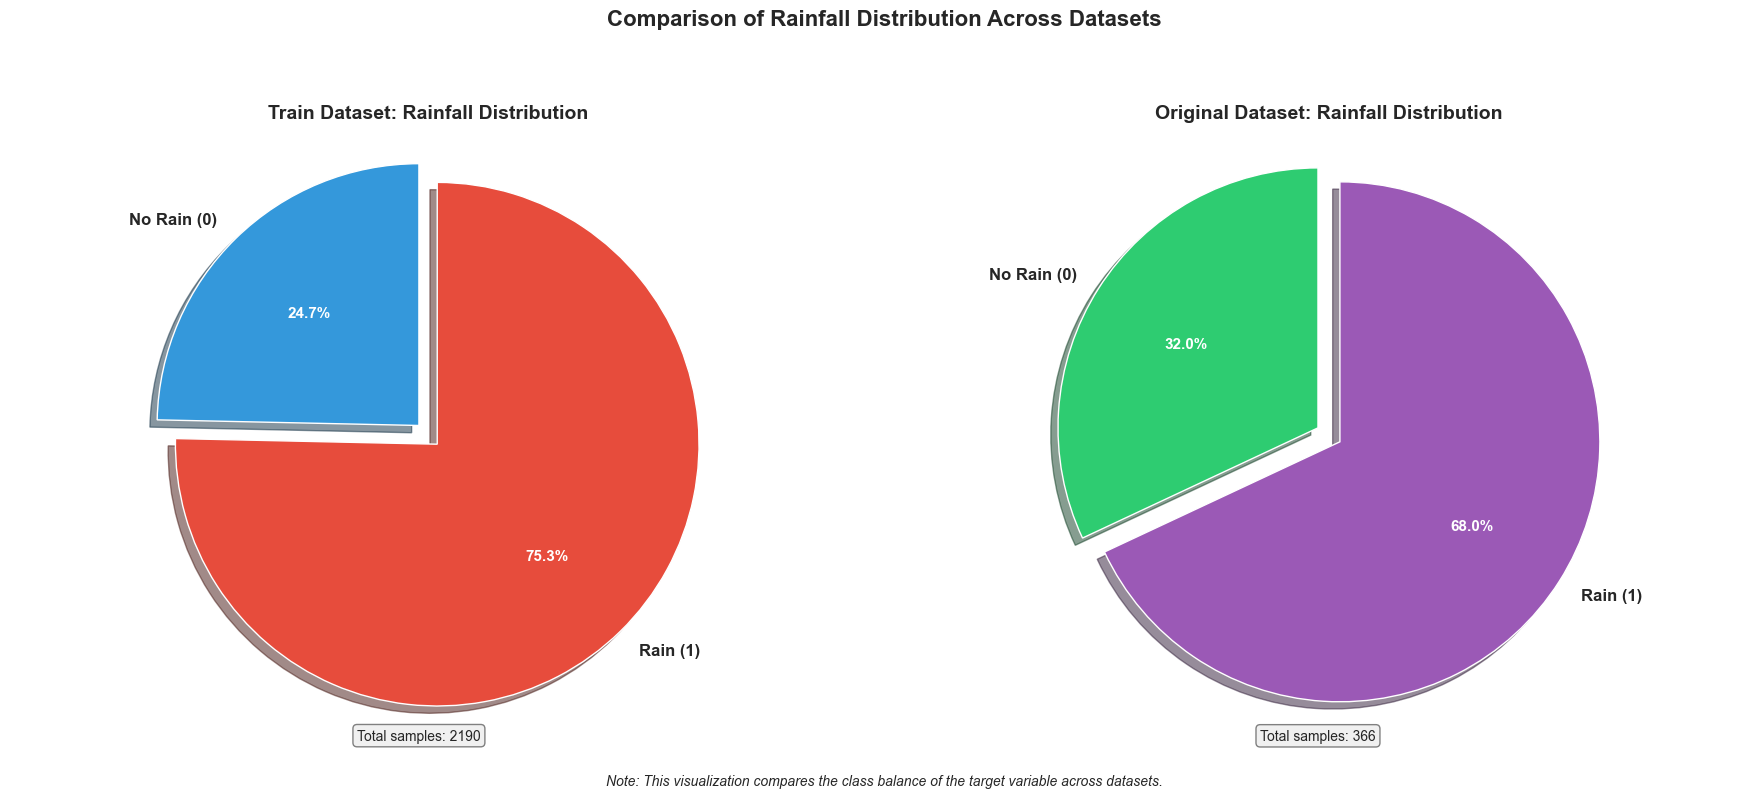

In [40]:
#EDA
def plot_rainfall_distribution(data, title, ax, colors=None, shadow=True, startangle=90):
    """
    Create an enhanced pie chart showing the distribution of rainfall.
    
    Parameters:
        data (DataFrame): The dataset containing the target variable
        title (str): Title for the pie chart
        ax (matplotlib.axes): The axis to plot on
        colors (list, optional): Custom colors for the pie slices
        shadow (bool, optional): Whether to draw a shadow beneath the pie
        startangle (int, optional): Starting angle for the pie chart
    """
    # Count values in the target column
    data_counts = data[target].value_counts().sort_index()
    
    # Define labels based on the binary target values
    labels = ['No Rain (0)', 'Rain (1)']
    
    # Get the corresponding values
    sizes = [data_counts.get(0, 0), data_counts.get(1, 0)]
    
    # Set default colors if not provided
    if colors is None:
        colors = ['#3498db', '#e74c3c']  # Blue for no rain, Red for rain
    
    # Set explosion to emphasize the "Rain" slice
    explode = (0, 0.1)
    
    # Create the pie chart
    wedges, texts, autotexts = ax.pie(
        sizes, 
        explode=explode, 
        labels=labels, 
        colors=colors, 
        autopct='%1.1f%%', 
        shadow=shadow, 
        startangle=startangle,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}
    )
    
    # Customize text appearance
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
        autotext.set_color('white')
    
    # Add dataset size information
    ax.text(
        0, -1.2, 
        f"Total samples: {len(data)}", 
        ha='center', 
        fontsize=10, 
        bbox=dict(boxstyle="round,pad=0.3", fc='#f0f0f0', ec='gray')
    )
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')
    
    # Set title with enhanced formatting
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Custom color pairs (colorblind-friendly)
custom_colors = [['#3498db', '#e74c3c'], ['#2ecc71', '#9b59b6']]

# Plot each distribution with different color schemes
plot_rainfall_distribution(train_copy, "Train Dataset: Rainfall Distribution", axes[0], colors=custom_colors[0])
plot_rainfall_distribution(original, "Original Dataset: Rainfall Distribution", axes[1], colors=custom_colors[1])

# Add a main title for the figure
fig.suptitle('Comparison of Rainfall Distribution Across Datasets', fontsize=16, fontweight='bold', y=0.98)

# Add footnote with data details
footnote = "Note: This visualization compares the class balance of the target variable across datasets."
plt.figtext(0.5, 0.01, footnote, ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

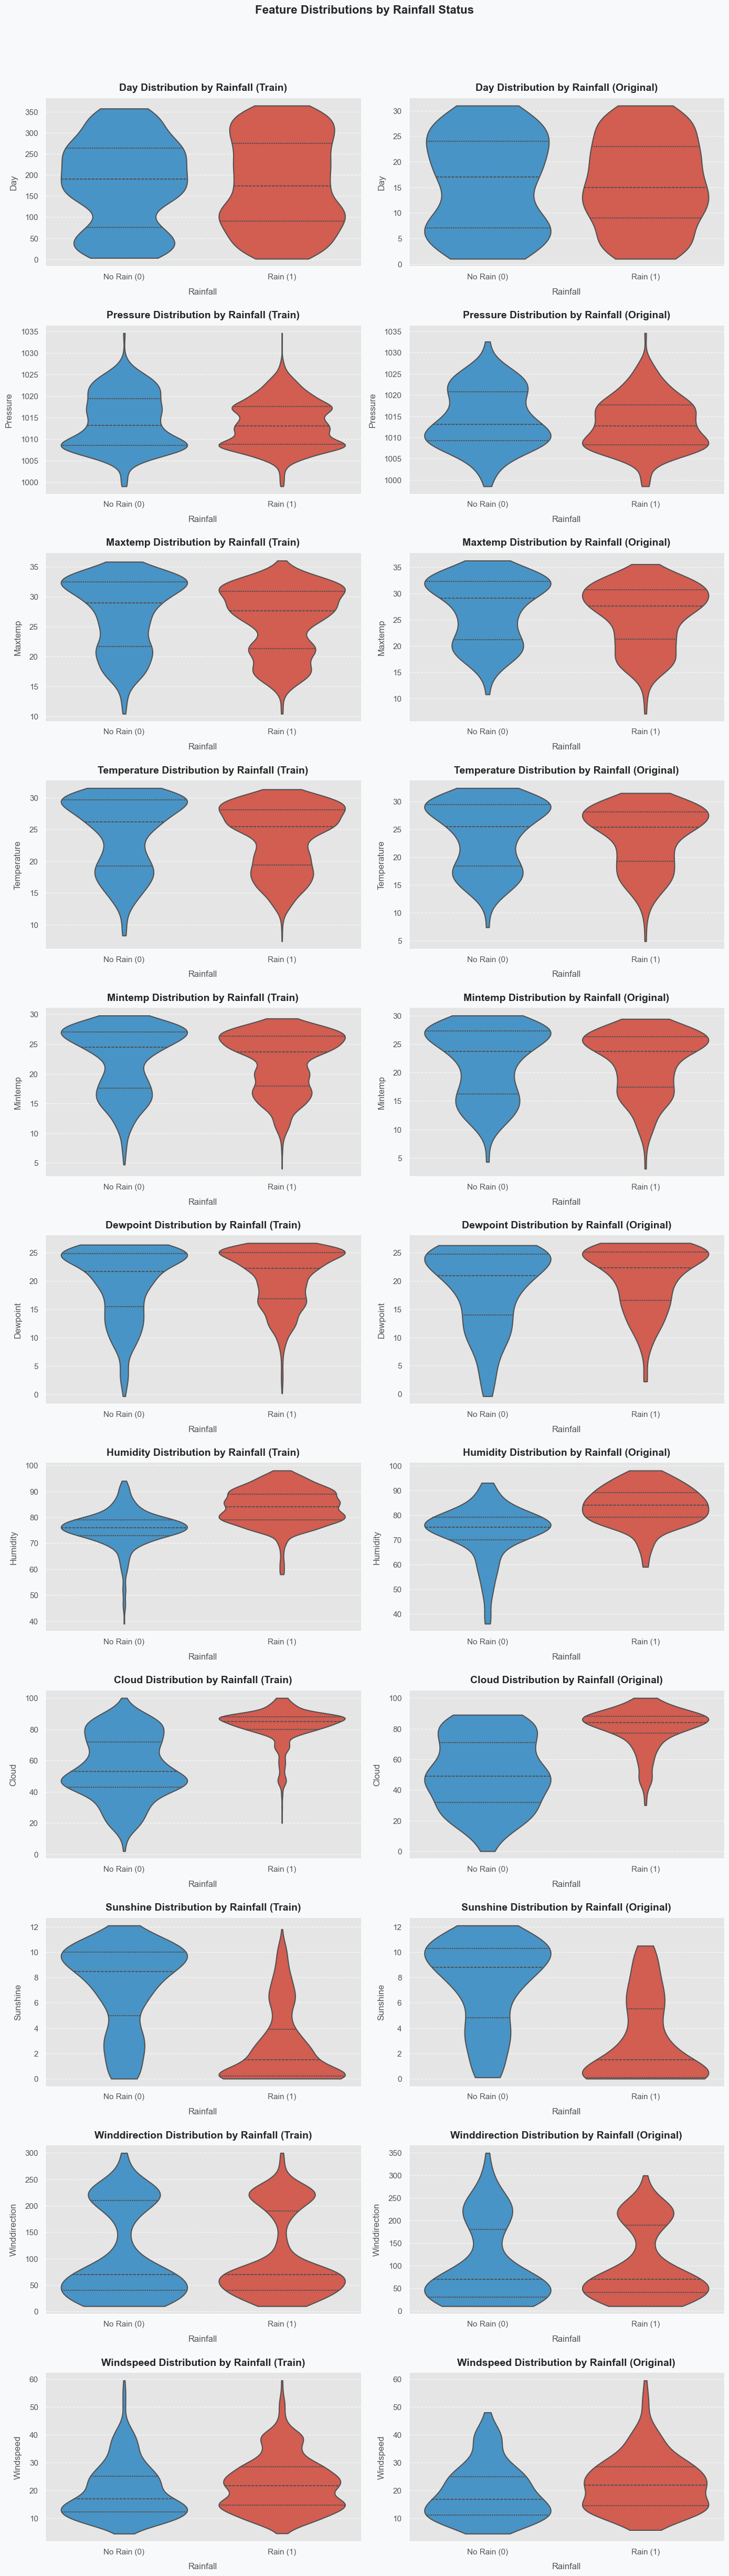

In [42]:
# Define a more visually appealing color palette
custom_palette = ["#3498db", "#e74c3c"]  # Professional blue and red

# Set figure style
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Get continuous columns
cont_cols = [f for f in train.columns if train[f].dtype != 'O' and train[f].nunique()>2]
n_rows = len(cont_cols)

# Create figure with improved sizing
fig, axs = plt.subplots(n_rows, 2, figsize=(14, 4.5 * n_rows), dpi=100)

# Ensure axs is always 2D
if n_rows == 1:
    axs = np.array([axs])

# Set plot background
fig.patch.set_facecolor('#f8f9fa')

# Create violin plots with enhanced styling
for i, col in enumerate(cont_cols):
    # Train plot
    sns.violinplot(
        x=target, 
        y=col, 
        data=train_copy, 
        ax=axs[i, 0],
        palette=custom_palette,
        inner='quartile',  # Show quartiles inside
        linewidth=1.5,
        cut=0  # Show full distribution
    )
    
    axs[i, 0].set_title(f'{col.title()} Distribution by Rainfall (Train)', 
                       fontsize=14, fontweight='bold', pad=10)
    axs[i, 0].set_xlabel('Rainfall', fontsize=12, labelpad=10)
    axs[i, 0].set_ylabel(col.title(), fontsize=12, labelpad=10)
    axs[i, 0].tick_params(labelsize=11)
    axs[i, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Original plot
    sns.violinplot(
        x=target, 
        y=col, 
        data=original, 
        ax=axs[i, 1],
        palette=custom_palette,
        inner='quartile',
        linewidth=1.5,
        cut=0
    )
    
    axs[i, 1].set_title(f'{col.title()} Distribution by Rainfall (Original)', 
                       fontsize=14, fontweight='bold', pad=10)
    axs[i, 1].set_xlabel('Rainfall', fontsize=12, labelpad=10)
    axs[i, 1].set_ylabel(col.title(), fontsize=12, labelpad=10)
    axs[i, 1].tick_params(labelsize=11)
    axs[i, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Improve x-axis labels for clarity
    for j in range(2):
        axs[i, j].set_xticklabels(['No Rain (0)', 'Rain (1)'])
    
    # Remove unnecessary spines
    sns.despine(ax=axs[i, 0])
    sns.despine(ax=axs[i, 1])

# Add a main title
fig.suptitle('Feature Distributions by Rainfall Status', 
            fontsize=16, fontweight='bold', y=0.99)

# Improve layout
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.35)
plt.show()

FEATURE ENGINEERING

In [43]:
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combines the data so that no category is missed and
    the category with least frequency can be dropped because of redundancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

In [44]:
#MISSING VALUES AND ANOMALIES

In [45]:
def fix_day_sequence_with_month_year(df, day_column='day', cycle_length=365):
    """
    Fixes day sequence anomalies and adds month and year columns.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with day column
    day_column (str): Name of column containing day values (default: 'day')
    cycle_length (int): Length of the cycle (default: 365 for year)
    
    Returns:
    pandas.DataFrame: DataFrame with corrected day sequence, month, and year columns
    """
    # Create a copy of the DataFrame
    df_fixed = df.copy()
    days = df_fixed[day_column].values
    
    # Initialize arrays for corrected days, months, and years
    fixed_days = np.zeros_like(days)
    months = np.zeros_like(days)
    years = np.ones_like(days)  # Start with year 1
    
    # Days in each month (non-leap year)
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    # Set first day
    current_day = 1
    current_month = 1
    current_year = 1
    day_of_year = 1
    
    fixed_days[0] = current_day
    months[0] = current_month
    years[0] = current_year
    
    # Process each day
    for i in range(1, len(days)):
        # Calculate expected next day
        expected_next = current_day + 1 if current_day < cycle_length else 1
        
        # Current value from data
        current_value = days[i]
        
        # Check if current value follows the sequence
        if (current_value == expected_next) or \
           (abs(current_value - expected_next) <= 5 and current_value <= cycle_length) or \
           (current_day == cycle_length and current_value == 1):
            current_day = current_value
        else:
            current_day = expected_next
            
        day_of_year = current_day if current_day != 1 else 1
        if current_day == 1 and i > 0:
            current_year += 1
        
        # Calculate month based on day of year
        cumulative_days = 0
        for month, days_in_month in enumerate(days_per_month, 1):
            if day_of_year <= cumulative_days + days_in_month:
                current_month = month
                break
            cumulative_days += days_in_month
        
        fixed_days[i] = current_day
        months[i] = current_month
        years[i] = current_year
    
    # Assign corrected values to DataFrame
    df_fixed[day_column] = fixed_days
    df_fixed['month'] = months
    df_fixed['year'] = years
    
    return df_fixed

train = fix_day_sequence_with_month_year(train)
test = fix_day_sequence_with_month_year(test)


In [46]:
def handle_missing_values(train_df, test_df, target="rainfall", n_components=1):
    """
    Process numerical datasets with missing values by:
    1. Imputing missing values using median
    2. Creating missing value indicators
    3. Applying SVD to combine indicator columns
    
    Parameters:
    -----------
    train_df : pandas DataFrame
        Training dataset with missing values (numerical only)
    test_df : pandas DataFrame
        Testing dataset with missing values (numerical only)
    target : str, default="rainfall"
        Name of the target variable (will be excluded from imputation and processing)
    n_components : int, default=1
        Number of components to keep after SVD
        
    Returns:
    --------
    train_processed : pandas DataFrame
        Processed training data with imputed values and SVD features
    test_processed : pandas DataFrame
        Processed testing data with imputed values and SVD features
    """
    # Create copies to avoid modifying the original datasets
    train_processed = train_df.copy()
    test_processed = test_df.copy()
    
    # Handle the target column
    y_train = None
    if target in train_df.columns:
        y_train = train_processed[target].copy()
        train_processed = train_processed.drop(columns=[target])
    
    # Get feature columns (excluding target)
    train_features = train_processed.columns.tolist()
    
    # Get common features between train and test
    common_features = [col for col in train_features if col in test_df.columns]
    
    # Only use common features for imputation to ensure consistency
    train_subset = train_processed[common_features]
    test_subset = test_processed[common_features]
    
    # Step 1: Imputation - Create simple imputer for numeric columns
    numeric_imputer = SimpleImputer(strategy='median')
    
    # Fit imputer only on common features
    numeric_imputer.fit(train_subset)
    
    # Transform both datasets
    train_imputed_values = numeric_imputer.transform(train_subset)
    test_imputed_values = numeric_imputer.transform(test_subset)
    
    # Create DataFrames from imputed values
    train_imputed = pd.DataFrame(
        train_imputed_values,
        columns=common_features,
        index=train_processed.index
    )
    
    test_imputed = pd.DataFrame(
        test_imputed_values,
        columns=common_features,
        index=test_processed.index
    )
    
    # Add back non-common features to train (not imputed)
    non_common_features = [col for col in train_features if col not in common_features]
    for col in non_common_features:
        train_imputed[col] = train_processed[col]
    
    # Step 2: Create missing value indicators for common features
    indicator_cols = []
    for col in common_features:
        indicator_name = f'{col}_missing'
        train_imputed[indicator_name] = train_df[col].isna().astype(int)
        test_imputed[indicator_name] = test_df[col].isna().astype(int)
        indicator_cols.append(indicator_name)
    
    # Step 3: Apply SVD to combine indicator columns into fewer dimensions
    if indicator_cols and len(indicator_cols) > 1:  # Only apply SVD if we have multiple indicators
        # Initialize SVD with specified number of components
        svd = TruncatedSVD(n_components=min(n_components, len(indicator_cols)))
        
        # Fit SVD on training data indicators and transform both datasets
        missing_indicators_train = train_imputed[indicator_cols].values
        missing_indicators_test = test_imputed[indicator_cols].values
        
        # Only proceed with SVD if we have missing values
        if np.any(missing_indicators_train):
            # Fit and transform
            missing_svd_train = svd.fit_transform(missing_indicators_train)
            missing_svd_test = svd.transform(missing_indicators_test)
            
            # Add SVD components to the datasets
            for i in range(n_components):
                train_imputed[f'missing_svd_{i}'] = missing_svd_train[:, i]
                test_imputed[f'missing_svd_{i}'] = missing_svd_test[:, i]
            
            # Optionally drop the original indicator columns if they're no longer needed
            train_imputed.drop(columns=indicator_cols, inplace=True)
            test_imputed.drop(columns=indicator_cols, inplace=True)
    
    # Add back the target column to the training data if it existed
    if y_train is not None:
        train_imputed[target] = y_train
    
    return train_imputed, test_imputed
    
train_imputed, test_imputed = handle_missing_values(train, test, n_components=1)


In [47]:
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combines the data so that no category is missed and
    the category with least frequency can be dropped because of redundancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

In [48]:
#Derived Features

In [49]:
def engineer_features(df):
    """
    Create new features based on meteorological understanding and data analysis,
    with 'day' representing day of the year (1-365).
    Ensures no data leakage by avoiding use of the target variable (rainfall).
    """
    # Make a copy to avoid modifying the original dataframe
    enhanced_df = df.copy()
    
    # 1. Temperature range (difference between max and min temperatures)
    enhanced_df['temp_range'] = enhanced_df['maxtemp'] - enhanced_df['mintemp']
    
    # 2. Dew point depression (difference between temperature and dew point)
    enhanced_df['dewpoint_depression'] = enhanced_df['temperature'] - enhanced_df['dewpoint']
    
    # 3. Pressure change from previous day
    enhanced_df['pressure_change'] = enhanced_df['pressure'].diff().fillna(0)
    
    # 4. Humidity to dew point ratio
    enhanced_df['humidity_dewpoint_ratio'] = enhanced_df['humidity'] / enhanced_df['dewpoint'].clip(lower=0.1)
    
    # 5. Cloud coverage to sunshine ratio (inverse relationship)
    enhanced_df['cloud_sunshine_ratio'] = enhanced_df['cloud'] / enhanced_df['sunshine'].clip(lower=0.1)
    
    # 6. Wind intensity factor (combination of speed and humidity)
    enhanced_df['wind_humidity_factor'] = enhanced_df['windspeed'] * (enhanced_df['humidity'] / 100)
    
    # 7. Temperature-humidity index (simple version of heat index)
    enhanced_df['temp_humidity_index'] = (0.8 * enhanced_df['temperature']) + \
                                        ((enhanced_df['humidity'] / 100) * \
                                        (enhanced_df['temperature'] - 14.3)) + 46.4
    
    # 8. Pressure change rate (acceleration)
    enhanced_df['pressure_acceleration'] = enhanced_df['pressure_change'].diff().fillna(0)
    
    # 9. Seasonal features (based on day of year)
    # Convert day to month (1-365 to 1-12)
    # enhanced_df['month'] = ((enhanced_df['day'] - 1) // 30) + 1
    # enhanced_df['month'] = enhanced_df['month'].clip(upper=12)  # Ensure month doesn't exceed 12
    
    # 10. Convert day to season (1-365 to 1-4)
    enhanced_df['season'] = ((enhanced_df['month'] - 1) // 3) + 1
    
    # 11. Sine and cosine transformations to capture cyclical nature of days in a year
    enhanced_df['day_of_year_sin'] = np.sin(2 * np.pi * enhanced_df['day'] / 365)
    enhanced_df['day_of_year_cos'] = np.cos(2 * np.pi * enhanced_df['day'] / 365)
    
    # 12. Rolling averages for key meteorological variables
    for window in [3, 7, 14]:
        enhanced_df[f'temperature_rolling_{window}d'] = enhanced_df['temperature'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'pressure_rolling_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'humidity_rolling_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'cloud_rolling_{window}d'] = enhanced_df['cloud'].rolling(window=window, min_periods=1).mean()
        enhanced_df[f'windspeed_rolling_{window}d'] = enhanced_df['windspeed'].rolling(window=window, min_periods=1).mean()
    
    # 13. Weather pattern change features
    # Temperature trend
    enhanced_df['temp_trend_3d'] = enhanced_df['temperature'].diff(3).fillna(0)
    # Pressure trend
    enhanced_df['pressure_trend_3d'] = enhanced_df['pressure'].diff(3).fillna(0)
    # Humidity trend
    enhanced_df['humidity_trend_3d'] = enhanced_df['humidity'].diff(3).fillna(0)
    
    # 14. Extreme weather indicators
    enhanced_df['extreme_temp'] = (enhanced_df['temperature'] > enhanced_df['temperature'].quantile(0.95)) | \
                                 (enhanced_df['temperature'] < enhanced_df['temperature'].quantile(0.05))
    enhanced_df['extreme_temp'] = enhanced_df['extreme_temp'].astype(int)
    
    enhanced_df['extreme_humidity'] = (enhanced_df['humidity'] > enhanced_df['humidity'].quantile(0.95)) | \
                                     (enhanced_df['humidity'] < enhanced_df['humidity'].quantile(0.05))
    enhanced_df['extreme_humidity'] = enhanced_df['extreme_humidity'].astype(int)
    
    enhanced_df['extreme_pressure'] = (enhanced_df['pressure'] > enhanced_df['pressure'].quantile(0.95)) | \
                                     (enhanced_df['pressure'] < enhanced_df['pressure'].quantile(0.05))
    enhanced_df['extreme_pressure'] = enhanced_df['extreme_pressure'].astype(int)
    
    # 15. Interaction terms between key variables
    enhanced_df['temp_humidity_interaction'] = enhanced_df['temperature'] * enhanced_df['humidity']
    enhanced_df['pressure_wind_interaction'] = enhanced_df['pressure'] * enhanced_df['windspeed']
    enhanced_df['cloud_sunshine_interaction'] = enhanced_df['cloud'] * enhanced_df['sunshine']
    enhanced_df['dewpoint_humidity_interaction'] = enhanced_df['dewpoint'] * enhanced_df['humidity']
    
    # 16. Moving standard deviations for measuring variability
    for window in [7, 14]:
        enhanced_df[f'temp_std_{window}d'] = enhanced_df['temperature'].rolling(window=window, min_periods=4).std().fillna(0)
        enhanced_df[f'pressure_std_{window}d'] = enhanced_df['pressure'].rolling(window=window, min_periods=4).std().fillna(0)
        enhanced_df[f'humidity_std_{window}d'] = enhanced_df['humidity'].rolling(window=window, min_periods=4).std().fillna(0)
    
    return enhanced_df
    
train_fe=engineer_features(train_imputed)
test_fe=engineer_features(test_imputed)

In [50]:
#FEATURE SELECTION

In [51]:
final_features=[f for f in train_fe.columns if f not in [target]]
final_features=[*set(final_features)]

sc=StandardScaler()

train_scaled=train_fe.copy()
test_scaled=test_fe.copy()
train_scaled[final_features]=sc.fit_transform(train_fe[final_features])
test_scaled[final_features]=sc.transform(test_fe[final_features])

In [52]:
def post_processor(train, test):
    cols=train.drop(columns=[target]).columns
    train_cop=train.copy()
    test_cop=test.copy()
    drop_cols=[]
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols,inplace=True)
    test_cop.drop(columns=drop_cols,inplace=True)
    
    return train_cop, test_cop

                    
train_cop, test_cop=   post_processor(train_scaled, test_scaled)   

X_train = train_cop.drop(columns=[target])
y_train = train[target]

X_test = test_cop.copy()

print(X_train.shape, X_test.shape)

[]
(2556, 57) (730, 57)


In [53]:
def get_most_important_features(X_train, y_train, n,model_input):
    xgb_params = {
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    if device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'
    lgb_params = {
            'objective': 'binary',
            'metric': 'logloss',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'device': device,
            'verbose':-1
        }
    cb_params = {
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'random_state': 42,
            'task_type': device.upper(),
        }
    if 'xgb' in model_input:
        model = xgb.XGBClassifier(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostClassifier(**cb_params)
    else:
        model=lgb.LGBMClassifier(**lgb_params)
        
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    feature_importances_list = []
    
    for train_idx, val_idx in kfold.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        if "lgb" not in model_input:
            model.fit(X_train_fold, y_train_fold, verbose=False)
        else:
            model.fit(X_train_fold, y_train_fold)
            
        
        y_pred = model.predict_proba(X_val_fold)[:,1]
        auc_scores.append(roc_auc_score(y_val_fold, y_pred))
        feature_importances = model.feature_importances_
        feature_importances_list.append(feature_importances)

    avg_auc= np.mean(auc_scores)
    avg_feature_importances = np.mean(feature_importances_list, axis=0)

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(avg_feature_importances)]
    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
    top_n_features = [feature[0] for feature in sorted_features[:n]]

    display_features=top_n_features[:10]
    
    sns.set_palette("Set2")
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(display_features)), [avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features])
    plt.yticks(range(len(display_features)), display_features, fontsize=12)
    plt.xlabel('Average Feature Importance', fontsize=14)
    plt.ylabel('Features', fontsize=10)
    plt.title(f'Top {10} of {n} Feature Importances with ROC AUC score {avg_auc}', fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add data labels on the bars
    for index, value in enumerate([avg_feature_importances[X_train.columns.get_loc(feature)] for feature in display_features]):
        plt.text(value + 0.005, index, f'{value:.3f}', fontsize=12, va='center')

    plt.tight_layout()
    plt.show()

    return top_n_features

In [55]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np

def get_most_important_features(X, y, top_n=50, model_type='xgb'):
    """
    Train a model and return top N most important features.

    Parameters:
    - X: pd.DataFrame, input features
    - y: pd.Series or np.array, target
    - top_n: int, number of top features to return
    - model_type: str, one of ['cat', 'xgb', 'lgbm']

    Returns:
    - top_features: list of feature names
    """

    if model_type == 'cat':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_type == 'lgbm':
        model = LGBMClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError("Invalid model_type. Choose from 'cat', 'xgb', 'lgbm'.")

    model.fit(X, y)
    importances = model.feature_importances_

    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })

    top_features = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)

    return top_features['Feature'].tolist()


In [56]:
n_imp_features_cat = get_most_important_features(X_train, y_train, 50, 'cat')   # uses RandomForest
n_imp_features_xgb = get_most_important_features(X_train, y_train, 50, 'xgb')   # uses XGBoost
n_imp_features_lgbm = get_most_important_features(X_train, y_train, 50, 'lgbm') # uses LightGBM

[LightGBM] [Info] Number of positive: 1899, number of negative: 657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10581
[LightGBM] [Info] Number of data points in the train set: 2556, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742958 -> initscore=1.061399
[LightGBM] [Info] Start training from score 1.061399


In [57]:
n_imp_features=[*set(n_imp_features_xgb+n_imp_features_lgbm+n_imp_features_cat)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

52 features have been selected from three algorithms for the final model


In [58]:
#MODELING

In [59]:
#class weights

In [60]:
classes = np.unique(y_train)  
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
y_train_numeric = np.array([class_to_index[cls] for cls in y_train])

class_counts = np.bincount(y_train_numeric)

total_samples = len(y_train_numeric)

class_weights = total_samples / (len(classes) * class_counts)

class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

print("Class counts:", class_counts)
print("Total samples:", total_samples)
print("Class weights:", class_weights)
print("Class weights dictionary:", class_weights_dict)

Class counts: [ 657 1899]
Total samples: 2556
Class weights: [1.94520548 0.67298578]
Class weights dictionary: {np.int64(0): np.float64(1.9452054794520548), np.int64(1): np.float64(0.6729857819905213)}


In [61]:
#models

In [62]:
def optimizer():
    sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=True)
    rms = tensorflow.keras.optimizers.RMSprop()
    nadam=tensorflow.keras.optimizers.Nadam(
        learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
    )
    adam=tensorflow.keras.optimizers.Adam()
    adamW = keras.optimizers.AdamW(learning_rate=0.002,weight_decay=0.001, beta_1=0.9, beta_2=0.999)
    
    return sgd,rms,nadam, adamW,adam

def init_ann1(num_classes, input_dim):
    '''
    Initialize the artificial neural network (ANN) for multiclass classification
    '''

    sgd, rms, nadam, adamW, adam = optimizer()
    
    ann = Sequential()
    ann.add(Dense(16, input_dim=input_dim, kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dropout(0.1))
    # ann.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
    # ann.add(Dropout(0.1))
    ann.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    ann.add(Dropout(0.0))
    
    # Change the output layer to match the number of classes
    ann.add(Dense(num_classes, kernel_initializer='he_uniform', activation='softmax'))
    
    # Compile the model with categorical_crossentropy loss and accuracy metric
    ann.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return ann

def init_ann2(num_classes, input_dim):  
    sgd,rms,nadam, adamW, adam=optimizer()
    ann2 = Sequential()
    ann2.add(Dense(128, input_dim=X_test.shape[1], kernel_initializer='he_uniform', activation='relu'))
    ann2.add(Dropout(0.3))
    # ann2.add(Dense(32,  kernel_initializer='he_uniform', activation='relu'))
    # ann2.add(Dropout(0.1))
    ann2.add(Dense(4,  kernel_initializer='he_uniform', activation='relu'))
    ann2.add(Dropout(0.2))
#     ann2.add(Dense(16,  kernel_initializer='he_uniform', activation='relu'))
#     ann2.add(Dropout(0.1))

    ann2.add(Dense(num_classes, kernel_initializer='he_uniform', activation='softmax'))
    ann2.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return ann2

In [63]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val
                    
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        # self.len_models = len(self.models)
    def _define_model(self):
       
       # XGBoost parameters
       xgb_params = {
           'n_estimators': self.n_estimators,
           'learning_rate': 0.05,
           'max_depth': 4,
           'subsample': 0.8,
           'colsample_bytree': 0.1,
           'n_jobs': -1,
           'eval_metric': 'auc',  # Changed to binary error
           'objective': 'binary:logistic',  # Changed to binary objective
           'tree_method': 'hist',
           'verbosity': 0,
           'random_state': self.random_state,
       }
       
       if self.device == 'gpu':
           xgb_params['tree_method'] = 'gpu_hist'
           xgb_params['predictor'] = 'gpu_predictor'
    
       xgb_params2 = {
           'n_estimators': self.n_estimators,
           'gamma': 0.279,
           'max_depth': 10,
           'subsample': 0.325,
           'min_child_weight': 9,
           'colsample_bytree': 0.487,
           'learning_rate': 0.052,
           'reg_lambda': 0.0007,
           'reg_alpha': 0.371,
           'n_jobs': -1,
           'eval_metric': 'auc',  # Changed to binary
           'objective': 'binary:logistic',  # Changed to binary
           'tree_method': 'hist',
           'verbosity': 0,
           'random_state': self.random_state,
       }
    
       xgb_params3 = {
           'n_estimators': self.n_estimators,
           'gamma': 0.279,
           'max_depth': 10,
           'subsample': 0.325,
           'min_child_weight': 9,
           'colsample_bytree': 0.487,
           'learning_rate': 0.052,
           'reg_lambda': 0.0007,
           'reg_alpha': 0.371,
           'n_jobs': -1,
           'eval_metric': 'auc',
           'objective': 'binary:logistic',
           'tree_method': 'hist',
           'verbosity': 0,
           'device': 'cuda',
           'booster': 'gbtree',
           'random_state': self.random_state,
       }
    
       xgb_params4 = xgb_params.copy()
       xgb_params4.update({
           'subsample': 0.789,
           'max_depth': 5,
           'learning_rate': 0.161,
           'colsample_bytree': 0.243
       })
    
       xgb_params5 = {
           'gamma': 0.3096433389022722, 
           'max_depth': 13, 
           'subsample': 0.265592840463903, 
           'min_child_weight': 5, 
           'colsample_bytree': 0.0750255657479969, 
           'learning_rate': 0.014300386108634659, 
           'reg_lambda': 0.07950866494906, 
           'reg_alpha': 0.003996021372821422,
            'n_jobs': -1,
           'eval_metric': 'auc',
           'objective': 'binary:logistic',
           'tree_method': 'hist',
           'verbosity': 0,
           'device': 'cuda',
           'booster': 'gbtree',
           'random_state': self.random_state,}
    
       # LightGBM parameters
       lgb_params = {
           'n_estimators': self.n_estimators,
           'max_depth': 10, 
           'min_samples_leaf': 33, 
           'subsample': 0.8144362305468624, 
           'learning_rate': 0.00647777270150904, 
           'lambda_l1': 1.2991459277687692e-05, 
           'lambda_l2': 0.0007304768170358017,
           'objective': 'binary',  # Changed to binary
           'metric': 'auc',  # Changed to binary error
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
       }
    
       lgb_params2 = {
           'n_estimators':self.n_estimators,
           'max_depth': 6,
           'subsample': 0.743,
           'learning_rate': 0.049,
           'lambda_l1': 8.922e-05,
           'lambda_l2': 0.0018,
           'colsample_bytree': 0.392,
           'objective': 'binary',
           'metric': 'auc',
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
       }
    
       lgb_params3 = {
           'n_estimators': self.n_estimators,
           'max_depth': 9,
           'subsample': 0.540,
           'learning_rate': 0.049,
           'lambda_l1': 1.749e-08,
           'lambda_l2': 3.837,
           'colsample_bytree': 0.319,
           'objective': 'binary',
           'metric': 'auc',
           'boosting_type': 'gbdt',
           'device': self.device,
           'random_state': self.random_state,
           'verbose': -1
       }
    
       lgb_params4 = lgb_params2.copy()
       lgb_params4.update({
           'subsample': 0.9,
           'reg_lambda': 0.876,
           'reg_alpha': 0.319,
           'max_depth': 9,
           'learning_rate': 0.107,
           'colsample_bytree': 0.1
       })
    
       lgb_params5 = lgb_params2.copy()
       lgb_params5.update({
           'subsample': 0.9,
           'reg_lambda': 0.512,
           'reg_alpha': 0.898,
           'max_depth': 11,
           'learning_rate': 0.081,
           'colsample_bytree': 0.1
       })
    
       # CatBoost parameters
       cb_params = {
           'iterations': self.n_estimators,
           'depth': 6,
           'learning_rate': 0.05,
           'l2_leaf_reg': 0.7,
           'random_strength': 0.2,
           'max_bin': 200,
           'od_wait': 65,
           'one_hot_max_size': 70,
           'grow_policy': 'Depthwise',
           'bootstrap_type': 'Bayesian',
           'od_type': 'Iter',
           'eval_metric': 'AUC',
           'loss_function': 'Logloss',  # Changed to binary
           'task_type': self.device.upper(),
           'random_state': self.random_state,
           'verbose': -1
       }
    
       cb_sym_params = cb_params.copy()
       cb_sym_params['grow_policy'] = 'SymmetricTree'
    
       cb_loss_params = cb_params.copy()
       cb_loss_params['grow_policy'] = 'Lossguide'
    
       cb_params2 = cb_params.copy()
       cb_params2.update({
           'learning_rate': 0.019,
           'depth': 9,
           'random_strength': 0.3,
           'one_hot_max_size': 10,
           'max_bin': 100,
           'l2_leaf_reg': 0.419
       })
    
       cb_params3 = {
           'iterations': self.n_estimators,
           'depth': 8, 
           'learning_rate': 0.010264893665188225, 
           'l2_leaf_reg': 1.6429322134431932, 
           'random_strength': 0.7418687826801, 
           'max_bin': 180, 
           'one_hot_max_size': 59, 
           'grow_policy': 'Lossguide', 
           'od_wait': 80,
           'bootstrap_type': 'Bayesian',
           'od_type': 'Iter',
           'eval_metric': 'AUC',
           'loss_function': 'Logloss',
           'task_type': self.device.upper(),
           'random_state': self.random_state,
       }
    
       cb_params4 = cb_params.copy()
       cb_params4.update({
           'learning_rate': 0.143,
           'depth': 16,
           'random_strength': 0.596,
           # 'one_hot_max_size': 100,
           # 'max_bin': 150,
           'l2_leaf_reg': 0.384,
           'grow_policy': 'Lossguide'
       })
    
       # Other model parameters remain same
       dt_params = {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 0.843}
       etr_params = {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 0.668, 'bootstrap': True}
       hist_params = {'learning_rate': 0.058, 'n_iter_no_change': 795, 'max_depth': 4, 'min_samples_leaf': 17, 'max_leaf_nodes': 98, 'l2_regularization': 1.923e-07}
       rf_params = {'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 0.416}
       gbt_params = {'learning_rate': 0.136, 'max_depth': 4, 'min_samples_split': 17, 'min_samples_leaf': 15, 'subsample': 0.886, 'max_features': 0.611}
       knn_params = {'n_neighbors':101, "p":1}
       adb_params = {'n_estimators': 957, 'learning_rate': 0.663}
    
       models = {
           'xgb':  xgb.XGBClassifier(**xgb_params),
           # 'xgb2': xgb.XGBClassifier(**xgb_params2),
           # 'xgb3': xgb.XGBClassifier(**xgb_params3),
           # 'xgb4': xgb.XGBClassifier(**xgb_params4),
           # 'xgb5': xgb.XGBClassifier(**xgb_params5),
           # 'lgb':  lgb.LGBMClassifier(**lgb_params),
           # 'lgb2': lgb.LGBMClassifier(**lgb_params2),
           # 'lgb3': lgb.LGBMClassifier(**lgb_params3),
           # 'lgb4': lgb.LGBMClassifier(**lgb_params4),
           # 'lgb5': lgb.LGBMClassifier(**lgb_params5),
           # 'cat':  CatBoostClassifier(**cb_params),
           # 'cat2': CatBoostClassifier(**cb_params2),
           # 'cat3': CatBoostClassifier(**cb_params3),
           # 'cat4': CatBoostClassifier(**cb_params4),
           # "cat_sym": CatBoostClassifier(**cb_sym_params),
           # "cat_loss": CatBoostClassifier(**cb_loss_params),
           # 'hist_gbm': HistGradientBoostingClassifier(max_iter=self.n_estimators, **hist_params, random_state=self.random_state),
           # 'rf': RandomForestClassifier(n_estimators=250, **rf_params, random_state=self.random_state),
           # 'gbdt': GradientBoostingClassifier(**gbt_params, n_estimators=1000, random_state=self.random_state),            
           # 'ada': AdaBoostClassifier(**adb_params, random_state=self.random_state),
           # 'etr': ExtraTreesClassifier(**etr_params, random_state=self.random_state),
           # 'dt': DecisionTreeClassifier(**dt_params, random_state=self.random_state),
           'knn': KNeighborsClassifier(**knn_params),
           'svm': SVC(probability=True, random_state=self.random_state),
           # 'log_reg': LogisticRegression(max_iter=1000),
           # 'ridge': CalibratedClassifierCV(RidgeClassifierCV(alphas=[100.02]), method='sigmoid'),
           # 'elasticNet': LogisticRegressionCV(Cs=[0.044], l1_ratios=[0.977]),
           # 'ann1': init_ann1(1, X_test.shape[1]),  # Changed to 1 for binary
           # 'ann2': init_ann2(1, X_test.shape[1]),  # Changed to 1 for binary
       }
       return models

In [64]:
#Optuna-->Weighted Ensemble

In [65]:
class OptunaWeights:
    """
    Advanced ensemble weight optimization using Optuna.
    This class optimizes weights for model predictions to maximize classification metrics.
    """
    def __init__(self, random_state, n_trials=5000, metric='auc', 
                 sampler_type='tpe', direction='maximize', timeout=None):
        """
        Initialize the OptunaWeights class.
        
        Args:
            random_state (int): Random seed for reproducibility
            n_trials (int): Number of optimization trials
            metric (str): Metric to optimize ('auc', 'logloss', 'accuracy', 'f1')
            sampler_type (str): Type of sampler ('tpe', 'cmaes', 'random')
            direction (str): Optimization direction ('maximize' or 'minimize')
            timeout (int): Maximum time in seconds for optimization (None = no limit)
        """
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials
        self.metric = metric
        self.sampler_type = sampler_type
        self.direction = direction
        self.timeout = timeout
        self.best_score = None
        self.calibrated_threshold = 0.5  # Default threshold

    def _find_best_threshold(self, y_true, y_pred):
        """Find the optimal classification threshold."""
        best_threshold = 0.5
        best_f1 = 0
        
        # Test thresholds from 0.01 to 0.99 with 0.01 increments
        for threshold in np.arange(0.01, 1.0, 0.01):
            y_pred_binary = (y_pred > threshold).astype(int)
            f1 = f1_score(y_true, y_pred_binary)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                
        return best_threshold
    
    def _validate_inputs(self, y_true, y_preds):
        """Validate input shapes and types."""
        if not isinstance(y_preds, list):
            raise ValueError("y_preds must be a list of prediction arrays")
        
        if len(y_preds) == 0:
            raise ValueError("Empty predictions list")
            
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
                
        # Validate shapes
        for i, pred in enumerate(y_preds_np):
            if pred.shape[0] != y_true.shape[0]:
                raise ValueError(f"Shape mismatch in model {i}: {pred.shape} vs {y_true.shape}")
                
        return y_true, y_preds_np

    def _objective(self, trial, y_true, y_preds):
        """Optimization objective function."""
        # Define the weights for the predictions from each model
        weights = []
        for n in range(len(y_preds)):
            # Allow negative weights, which can be useful for certain ensembles
            weight = trial.suggest_float(f"weight{n}", -2, 2)
            weights.append(weight)
        
        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds), axis=0, weights=weights)
        
        # Normalize predictions to ensure they sum to 1 across classes
        if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
            # Multi-class case
            weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
        else:
            # Binary classification case - clip values to valid probability range
            weighted_pred = np.clip(weighted_pred, 0, 1)
        
        # Calculate metric based on selected option
        if self.metric == 'logloss':
            # For log loss, we want to minimize
            return log_loss(y_true, weighted_pred)
        elif self.metric == 'accuracy':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return accuracy_score(y_true, weighted_pred_labels)
        elif self.metric == 'f1':
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            weighted_pred_labels = (weighted_pred > threshold).astype(int)
            return f1_score(y_true, weighted_pred_labels)
        else:
            # Default to AUC
            return roc_auc_score(y_true, weighted_pred)

    def fit(self, y_true, y_preds, cv=None):
        """
        Fit the model to optimize ensemble weights.
        
        Args:
            y_true: True labels
            y_preds: List of model predictions
            cv: Optional cross-validation strategy for more robust weight optimization
        """
        # Validate inputs
        y_true, y_preds = self._validate_inputs(y_true, y_preds)
        
        # Set optimization verbosity
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        
        # Choose sampler based on configuration
        if self.sampler_type == 'cmaes':
            sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        elif self.sampler_type == 'random':
            sampler = optuna.samplers.RandomSampler(seed=self.random_state)
        else:
            # Default to TPE sampler which often works better than CMA-ES for this problem
            sampler = TPESampler(seed=self.random_state, multivariate=True)
        
        # Set pruner for early stopping
        pruner = optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        
        # Set optimization direction
        direction = self.direction
        if self.metric == 'logloss':
            # For log loss, we always want to minimize
            direction = 'minimize'
        
        # Create study
        self.study = optuna.create_study(
            sampler=sampler, 
            pruner=pruner, 
            study_name="OptunaWeights", 
            direction=direction
        )
        
        if cv is not None and cv > 1:
            # Use cross-validation for more robust weight optimization
            skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=self.random_state)
            cv_scores = []
            
            for train_idx, val_idx in skf.split(np.zeros(len(y_true)), y_true):
                y_true_val = y_true[val_idx]
                y_preds_val = [pred[val_idx] for pred in y_preds]
                
                # Optimize on this fold
                objective_partial = partial(self._objective, y_true=y_true_val, y_preds=y_preds_val)
                fold_study = optuna.create_study(sampler=sampler, direction=direction)
                fold_study.optimize(
                    objective_partial, 
                    n_trials=self.n_trials // cv,
                    timeout=None if self.timeout is None else self.timeout // cv
                )
                cv_scores.append(fold_study.best_value)
            
            # Re-optimize on full dataset with more knowledge
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        else:
            # Standard optimization on the full dataset
            objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
            self.study.optimize(
                objective_partial, 
                n_trials=self.n_trials,
                timeout=self.timeout
            )
        
        # Extract the best weights
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]
        
        # Record the best score
        self.best_score = self.study.best_value
        
        # Find optimal threshold (for classification metrics)
        if 'threshold' in self.study.best_params:
            self.calibrated_threshold = self.study.best_params['threshold']
        else:
            weighted_pred = self.predict(y_preds)
            self.calibrated_threshold = self._find_best_threshold(y_true, weighted_pred)
        
        return self

    def predict(self, y_preds, normalize=True):
        """
        Make predictions using optimized weights.
        
        Args:
            y_preds: List of model predictions
            normalize: Whether to normalize predictions
            
        Returns:
            Weighted prediction
        """
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        
        # Convert to numpy arrays if needed
        y_preds_np = []
        for pred in y_preds:
            if isinstance(pred, np.ndarray):
                y_preds_np.append(pred)
            else:
                y_preds_np.append(np.array(pred))
        
        # Calculate weighted predictions
        weighted_pred = np.average(np.array(y_preds_np), axis=0, weights=self.weights)
        
        # Normalize if requested
        if normalize:
            if len(weighted_pred.shape) > 1 and weighted_pred.shape[1] > 1:
                # Multi-class case
                weighted_pred = weighted_pred / weighted_pred.sum(axis=1, keepdims=True)
            else:
                # Binary classification - clip to valid probability range
                weighted_pred = np.clip(weighted_pred, 0, 1)
                
        return weighted_pred

    def predict_classes(self, y_preds):
        """
        Predict class labels using the optimized threshold.
        
        Args:
            y_preds: List of model predictions
            
        Returns:
            Class predictions
        """
        weighted_pred = self.predict(y_preds)
        return (weighted_pred > self.calibrated_threshold).astype(int)

    def fit_predict(self, y_true, y_preds, normalize=True):
        """
        Fit the model and return predictions in one step.
        
        Args:
            y_true: True labels
            y_preds: List of model predictions
            normalize: Whether to normalize predictions
            
        Returns:
            Weighted prediction
        """
        self.fit(y_true, y_preds)
        return self.predict(y_preds, normalize=normalize)

    def get_weights(self):
        """Return the optimized weights."""
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
        return self.weights
    
    def get_feature_importance(self):
        """
        Get the relative importance of each model in the ensemble.
        
        Returns:
            Dictionary mapping index to relative importance
        """
        if self.weights is None:
            raise ValueError("Model has not been fitted yet")
            
        # Get absolute weights
        abs_weights = np.abs(self.weights)
        total = np.sum(abs_weights)
        
        # Normalize to get relative importance
        if total > 0:
            importance = abs_weights / total
        else:
            importance = np.ones_like(abs_weights) / len(abs_weights)
            
        return {i: float(imp) for i, imp in enumerate(importance)}
    
    def get_search_statistics(self):
        """
        Get statistics from the optimization process.
        
        Returns:
            Dictionary with optimization statistics
        """
        if self.study is None:
            raise ValueError("Model has not been fitted yet")
            
        return {
            "best_score": self.best_score,
            "best_trial": self.study.best_trial.number,
            "n_trials": len(self.study.trials),
            "optimization_direction": self.study.direction.name,
            "calibrated_threshold": self.calibrated_threshold
        }

In [66]:
#Fit Models

In [68]:
def train_model(model, X_train, y_train, X_val, y_val, model_type='xgb', early_stopping_rounds=10, verbose=100):
    if model_type in ['xgb', 'lgbm']:
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='logloss',
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose
        )
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    return model

In [24]:
#ensemble weights

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)

    # If your model supports predict_proba, use it for AUC
    try:
        y_prob = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_prob)
    except:
        auc = None

    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')

    print("📊 Model Evaluation Metrics:")
    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"🎯 Precision: {precision:.4f}")
    print(f"🔁 Recall:    {recall:.4f}")
    print(f"📌 F1 Score:  {f1:.4f}")
    if auc is not None:
        print(f"🧠 ROC AUC:   {auc:.4f}")

    print("\n🧾 Classification Report:\n", classification_report(y_val, y_pred))
    print("🧮 Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


In [25]:
#submission

In [70]:
oof_predss.to_csv('oof_predss.csv',index=False)

submission[target] =  test_predss
submission.to_csv('submission_pure.csv',index=False)

submission.head()

,id,rainfall
0,2190,0.0
1,2191,0.0
2,2192,0.0
3,2193,0.0
4,2194,0.0
